## **Importing Libraries**

In [ ]:
!pip install keras

In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

## **Setting the Parameters**

In [3]:
directory_root = "./drive/MyDrive/PlantDiseaseExplanation/data/PlantDoc"

In [4]:
EPOCHS = 60
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
width=256
height=256
depth=3


## **Image Preprocessing**



1.   Converting image to array.
2.   Normalizing the pixel values.
3.   Data Augmentation by
     *   Rotating the images by 25 degrees.
     *   Shear (changing perception angles) (0.2 range).
     *   Zooming (0.2 range)
     *   Performing horizontal and vertical flip.















In [5]:
# Converts images to arrays.
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [6]:
# Loading the images and append the image and label arrays to lists.
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:250]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing grape leaf black rot ...
[INFO] Processing grape leaf ...
[INFO] Processing Peach leaf ...
[INFO] Processing Tomato leaf bacterial spot ...
[INFO] Processing Tomato mold leaf ...
[INFO] Processing Tomato two spotted spider mites leaf ...
[INFO] Processing Tomato leaf late blight ...
[INFO] Processing Tomato leaf yellow virus ...
[INFO] Processing Tomato Septoria leaf spot ...
[INFO] Processing Tomato leaf mosaic virus ...
[INFO] Processing Tomato Early blight leaf ...
[INFO] Processing Tomato leaf ...
[INFO] Processing Corn rust leaf ...
[INFO] Processing Corn leaf blight ...
[INFO] Processing Corn Gray leaf spot ...
[INFO] Processing Squash Powdery mildew leaf ...
[INFO] Processing Soyabean leaf ...
[INFO] Processing Potato leaf late blight ...
[INFO] Processing Potato leaf early blight ...
[INFO] Processing Strawberry leaf ...
[INFO] Processing Cherry leaf ...
[INFO] Processing Raspberry leaf ...
[INFO] Processing Apple Scab Leaf ...
[INFO]

In [7]:
image_size = len(image_list)
# Converting the labels to binary arrays.
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
# Saving the transformed labels.
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [8]:
# Normalizing the pixel values by diving with 255.0.
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
# Splitting the data into train and test sets with 80:20 ratio.
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state=42) 

In [9]:
# Data Augmentation.
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")


## **Creating functions for evaluation metrics (Precision, Recall, F1-score)**

Source: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

In [10]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## **Creating the CNN model with 5 layers.**

In [11]:
model_cnn = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model_cnn.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model_cnn.add(Activation("relu"))
model_cnn.add(BatchNormalization(axis=chanDim))
model_cnn.add(MaxPooling2D(pool_size=(3, 3)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Conv2D(64, (3, 3), padding="same"))
model_cnn.add(Activation("relu"))
model_cnn.add(BatchNormalization(axis=chanDim))
model_cnn.add(Conv2D(64, (3, 3), padding="same"))
model_cnn.add(Activation("relu"))
model_cnn.add(BatchNormalization(axis=chanDim))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Conv2D(128, (3, 3), padding="same"))
model_cnn.add(Activation("relu"))
model_cnn.add(BatchNormalization(axis=chanDim))
model_cnn.add(Conv2D(128, (3, 3), padding="same"))
model_cnn.add(Activation("relu"))
model_cnn.add(BatchNormalization(axis=chanDim))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten())
model_cnn.add(Dense(1024))
model_cnn.add(Activation("relu"))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(n_classes))
model_cnn.add(Activation("softmax"))

In [15]:
# Model Summary
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [12]:
# Initializing Adam Optimizer.
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# Choosing BCE loss and Accuracy as the metric.
model_cnn.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy", precision_m, recall_m, f1_m])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
# Traing the model.
history_cnn = model_cnn.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/60
63/63 [==============================] - 27s 388ms/step - loss: 0.6619 - accuracy: 0.0460 - precision_m: 0.0228 - recall_m: 0.0020 - f1_m: 0.0035 - val_loss: 0.5413 - val_accuracy: 0.0315 - val_precision_m: 0.0078 - val_recall_m: 0.0020 - val_f1_m: 0.0031
Epoch 2/60
63/63 [==============================] - 24s 373ms/step - loss: 0.2378 - accuracy: 0.0600 - precision_m: 0.0763 - recall_m: 0.0060 - f1_m: 0.0108 - val_loss: 2.7820 - val_accuracy: 0.0217 - val_precision_m: 0.0233 - val_recall_m: 0.0198 - val_f1_m: 0.0214
Epoch 3/60
63/63 [==============================] - 24s 375ms/step - loss: 0.2045 - accuracy: 0.0660 - precision_m: 0.0955 - recall_m: 0.0094 - f1_m: 0.0170 - val_loss: 0.4450 - val_accuracy: 0.0492 - val_precision_m: 0.1626 - val_recall_m: 0.0410 - val_f1_m: 0.0649
Epoch 4/60
63/63 [==============================] - 23s 372ms/step - loss: 0.1954 - accuracy: 0.0835 - precision_m: 0.1150 - recall_m: 0.0154 - f1_m: 0.0267 - val_loss: 0.2521 - val_accuracy: 0.0689 

In [14]:
# Saving the model for future use.
model_cnn.save('./drive/MyDrive/PlantDiseaseExplanation/code/saved_models/PlantVillage/CNN')

INFO:tensorflow:Assets written to: ./drive/MyDrive/PlantDiseaseExplanation/code/saved_models/PlantVillage/CNN/assets


## **CNN Results**



*   Training/ Validation accuracy Vs. Epochs
*   Training/ Validation accuracy Vs. Epochs



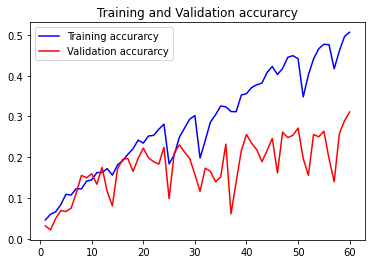

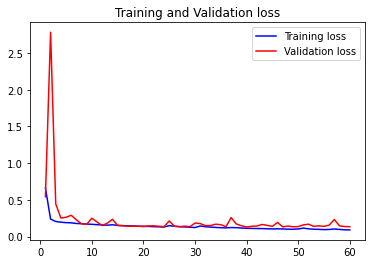

In [15]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [16]:
# Calculating the test accuracy.
print("The test accuracy is: \n")
loss, accuracy, precision, recall, f1 = model_cnn.evaluate(x_test, y_test, verbose=0)
scores = model_cnn.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}" + "%")

The test accuracy is: 

16/16 [==============================] - 0s 20ms/step - loss: 0.1337 - accuracy: 0.3110 - precision_m: 0.4336 - recall_m: 0.2118 - f1_m: 0.2822
Test Accuracy: 31.102362275123596%


In [17]:
len(x_test)

508

## **Local Explanation using LIME.**

In [18]:
!pip install lime

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random


     |████████████████████████████████| 275 kB 7.4 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=bffd9bd4bdaa5e5c1f1f27e1c3ef561fb59b48daa28e139067835235fa9de79e
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

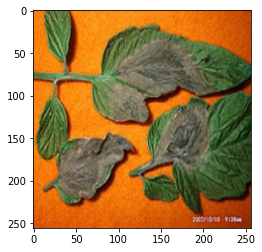

In [19]:
# Initializing the LIME explainer.
explainer = lime_image.LimeImageExplainer()
# Applying LIME to one of the images in the test set.
test_image = convert_image_to_array('./drive/MyDrive/PlantDiseaseExplanation/data/late_blight_tomato_leaf_cornell.jpeg')
# explanation = explainer.explain_instance((x_test[0]*255.0).astype('uint8'), model_cnn.predict)
explanation = explainer.explain_instance(test_image.astype('double'), model_cnn.predict)
# Displaying the original image.
plt.imshow(test_image.astype('uint8'))


In [20]:
len(test_image)

256

In [21]:
# Creating the LIME mask on the image.
image, mask = explanation.get_image_and_mask(
         model_cnn.predict(
              test_image.astype('uint8').reshape((1,256,256,3)
         )).argmax(axis=1)[0],
         positive_only=True, 
         hide_rest=False)

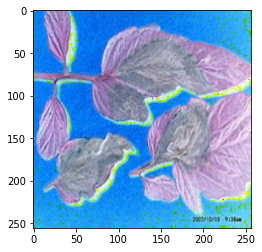

In [22]:
# Displayint the image after applying LIME. 
# The yellow part indicates the region which contributed in the prediction.
plt.imshow(mark_boundaries((image*255.0).astype('uint8'), mask))

In [23]:
# The predicted label for the above image.
label_binarizer.inverse_transform(model_cnn.predict(test_image.astype('uint8').reshape((1,256,256,3))))

array(['Tomato leaf'], dtype='<U36')

## **Transfer Learning using Keras**

Source: https://keras.io/guides/transfer_learning/

The workflow is: 
1. Taking layers from previously trained models.
2. Freezing them so as to avoid destroying any of the information they contain during future training rounds.
3. Add new trainable layers on the top of the frozen layers. They will learn to turn the old features into predictions on the new dataset.
4. Training new layers on our dataset.

In this project,
I will be using InceptionV3 model through transfer learning and using pretrained imagenet weights.

## **Training the InceptionV3 model**

In [24]:
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical

# Get the InceptionV3 model and using the pretrained imagenet weights.
base_inception = InceptionV3(weights='imagenet', include_top=False, 
                             input_shape=(256, 256, 3))
                             
# Applying global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model_inception = Model(inputs=base_inception.input, outputs=predictions)

# Freezing the layers.
for layer in base_inception.layers:
    layer.trainable = False
     
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model_inception.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy", precision_m, recall_m, f1_m]) 
model_inception.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 127, 127, 32  96         ['conv2d_5[0][0]']               
 rmalization)                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [25]:
history_inception = model_inception.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/60
63/63 [==============================] - 31s 419ms/step - loss: 0.1601 - accuracy: 0.1841 - precision_m: 0.3797 - recall_m: 0.0298 - f1_m: 0.0537 - val_loss: 0.1289 - val_accuracy: 0.2244 - val_precision_m: 0.4516 - val_recall_m: 0.0756 - val_f1_m: 0.1272
Epoch 2/60
63/63 [==============================] - 24s 388ms/step - loss: 0.1116 - accuracy: 0.3602 - precision_m: 0.6845 - recall_m: 0.1429 - f1_m: 0.2312 - val_loss: 0.1088 - val_accuracy: 0.3622 - val_precision_m: 0.6544 - val_recall_m: 0.1828 - val_f1_m: 0.2815
Epoch 3/60
63/63 [==============================] - 25s 389ms/step - loss: 0.0961 - accuracy: 0.4377 - precision_m: 0.7373 - recall_m: 0.2498 - f1_m: 0.3672 - val_loss: 0.1008 - val_accuracy: 0.4134 - val_precision_m: 0.6592 - val_recall_m: 0.2023 - val_f1_m: 0.3061
Epoch 4/60
63/63 [==============================] - 24s 387ms/step - loss: 0.0888 - accuracy: 0.4997 - precision_m: 0.7204 - recall_m: 0.3191 - f1_m: 0.4370 - val_loss: 0.1009 - val_accuracy: 0.3917 

## InceptionV3 Results

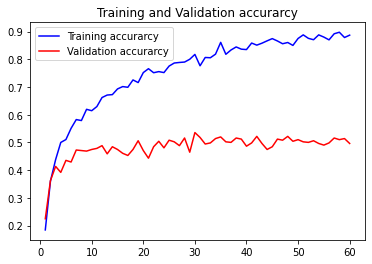

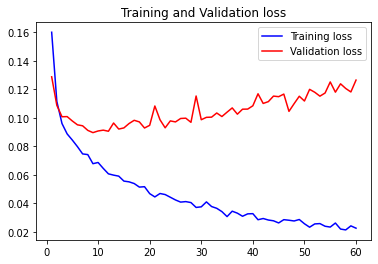

In [26]:
acc = history_inception.history['accuracy']
val_acc = history_inception.history['val_accuracy']
loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [27]:
# Calculating the test accuracy.
print("The test accuracy is: \n")
loss, accuracy, precision, recall, f1 = model_inception.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy*100}" + "%")

The test accuracy is: 

16/16 [==============================] - 1s 61ms/step - loss: 0.1265 - accuracy: 0.4961 - precision_m: 0.5454 - recall_m: 0.4835 - f1_m: 0.5119
Test Accuracy: 49.60629940032959%


  0%|          | 0/1000 [00:00<?, ?it/s]

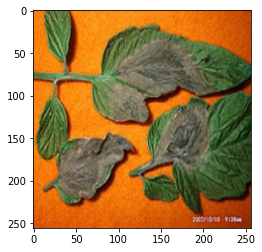

In [28]:
# Initializing the LIME explainer.
explainer = lime_image.LimeImageExplainer()
# Applying LIME to one of the images in the test set.
test_image = convert_image_to_array('./drive/MyDrive/PlantDiseaseExplanation/data/late_blight_tomato_leaf_cornell.jpeg')
# explanation = explainer.explain_instance((x_test[0]*255.0).astype('uint8'), model_cnn.predict)
explanation = explainer.explain_instance(test_image.astype('double'), model_inception.predict)
# Displaying the original image.
plt.imshow(test_image.astype('uint8'))

In [29]:
# Creating the LIME mask on the image.
image, mask = explanation.get_image_and_mask(
         model_inception.predict(
              test_image.astype('uint8').reshape((1,256,256,3)
         )).argmax(axis=1)[0],
         positive_only=True, 
         hide_rest=False)

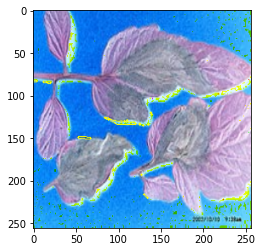

In [30]:
plt.imshow(mark_boundaries((image*255.0).astype('uint8'), mask))

In [31]:
label_binarizer.inverse_transform(model_inception.predict(test_image.astype('uint8').reshape((1,256,256,3))))

array(['Blueberry leaf'], dtype='<U36')